## Imports

In [146]:
import torch
from torch.utils.data import DataLoader

from src.utils_data import load_PeMS04_flow_data, preprocess_PeMS_data, createLoaders, TimeSeriesDataset
from src.utils_graph import compute_laplacian_with_self_loop
from src.models import TGCN, GRUModel, LSTMModel, train_model

import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Print Results

In [147]:
def result_prediction(predictions, actuals):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    y_pred = predictions[:]
    y_true = actuals[:]

    signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    if (mape > 1 or mape < 0):
        mape = "ERROR"
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
    maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100
    
    return [signe, mae, rmse, mape, smape, maape]

In [148]:
def highlight_rows(row, min_val, max_val):
    if row["MAAPE"] == min_val:
        color = "green"
    elif row["MAAPE"] == max_val:
        color = "red"
    else:
        color = ""
    return [f'background-color: {color}'] * len(row)

## Test Model

In [149]:
def test_model(best_model, test_loader):
    import numpy as np
    
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = (inputs).to(device)
            targets = (targets).squeeze().to(device)
            outputs = best_model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    test_loss /= len(test_loader)
    # print(f"Test Loss: {test_loss:.4f}")
    
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return (predictions, actuals)

## Parameters

In [150]:
n_neighbors = 49
normalization = "center_and_reduce"

# Define the sliding window size and stride
_window_size = 6
horizon = 1
_stride = horizon
path_save_model = f"./{normalization}/nb_captor_{n_neighbors+1}/windows_{_window_size}_out_{horizon}"

## Preprocessing data

In [151]:
df_PeMS_old, df_distance  = load_PeMS04_flow_data()
df_PeMS, adjacency_matrix_PeMS, meanstd_dict = preprocess_PeMS_data(df_PeMS, df_distance, init_node=0, n_neighbors=n_neighbors, center_and_reduce=True)

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


In [152]:
import matplotlib.pyplot as plt
def plot_losses(losses, title, label_line):
    plt.figure(figsize=(25, 9))
    plt.title(title)
    plt.plot(losses, label=label_line)
    plt.legend(fontsize=12)
    plt.show()

In [153]:
import copy
def create_multiple_model_with_one_captor(model, nb_model, name_dict, data, _windows_size, _stride):
    dict_model = {}
    for i in range(nb_model):
        #print(f"{name_dict}{i}")
        train_loader, val_loader, test_loader = createLoaders(pd.DataFrame(data.iloc[:, i]), window_size=_windows_size, stride=_stride, target_size=horizon)
        dict_model[f"{name_dict}{i}"] = {
                                "model": copy.deepcopy(model),
                                "train_loader": train_loader,
                                "val_loader": val_loader,
                                "test_loader": test_loader
        }
    return dict_model

## TGCN

In [154]:
train_loader_TGCN, val_loader_TGCN, test_loader_TGCN = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
model_TGCN = TGCN(adjacency_matrix_PeMS, hidden_dim=32, output_size=len(df_PeMS.columns))

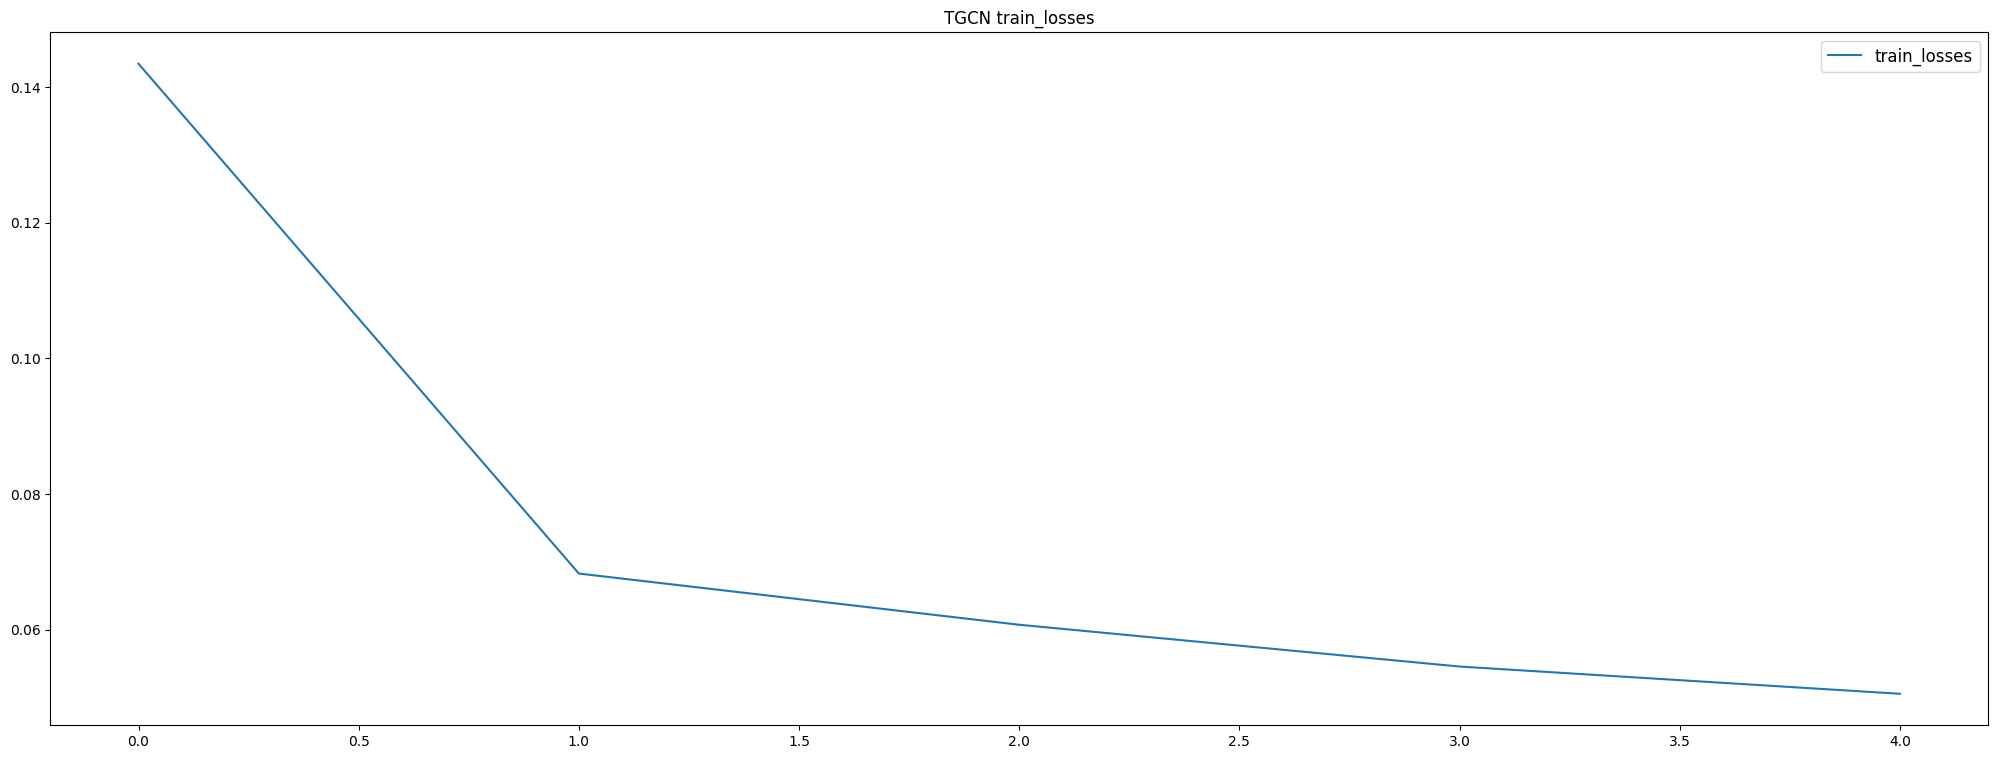

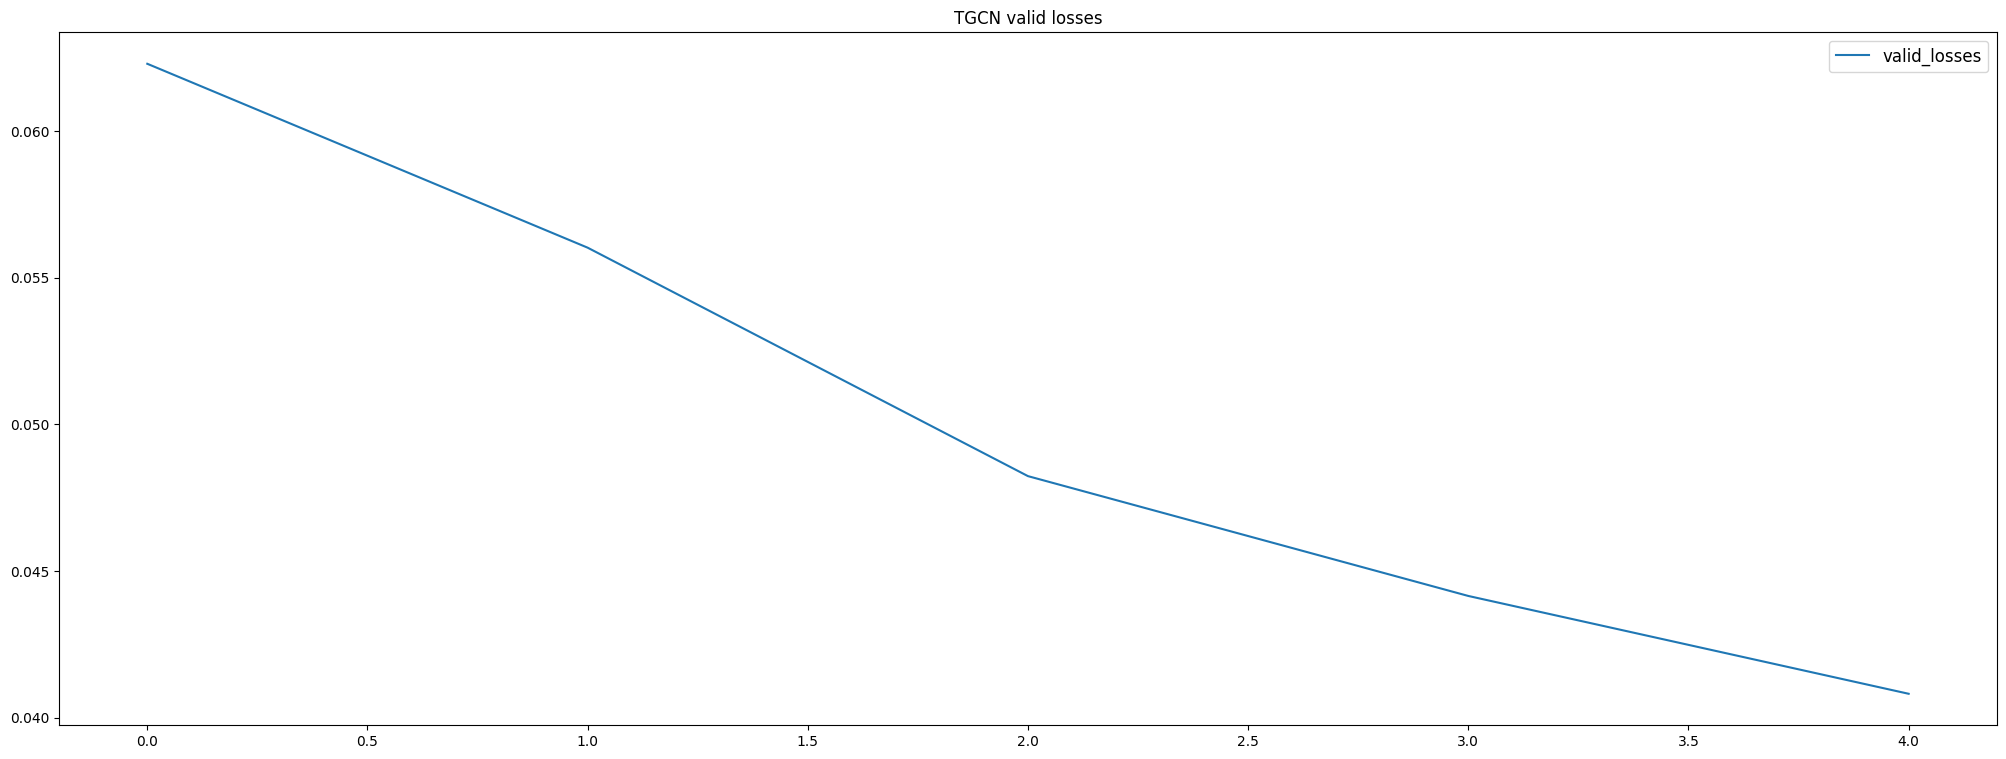

In [162]:
import matplotlib.pyplot as plt

num_epochs_TGCN = 5
model_path = f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl"
_ , valid_losses, train_losses = train_model(model_TGCN, train_loader_TGCN, val_loader_TGCN, model_path=model_path, num_epochs=num_epochs_TGCN, remove=False)

plot_losses(train_losses, "TGCN train_losses", "train_losses")
plot_losses(valid_losses, "TGCN valid losses", "valid_losses")


## Univariate 

In [156]:
# # LSTM
# num_epochs_LSTM_univariate = 3
# models_univaritate_LSTM = {}

# # GRU
# num_epochs_GRU_univaritate = 3
# models_univaritate_GRU = {}

In [157]:
# # LSTM
# models_univaritate_LSTM = create_multiple_model_with_one_captor(LSTMModel(1,32,1), n_neighbors+1, "LSTMModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["train_loader"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["val_loader"], 
#                 f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl", num_epochs=num_epochs_LSTM_univariate, remove=False)
#     plot_losses(train_losses, f"LSTM train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"LSTM valid_losses captor {df_PeMS.columns[i]}", "valid_losses")


# # GRU
# models_univaritate_GRU = create_multiple_model_with_one_captor(GRUModel(1, 32, 1), n_neighbors+1, "GRUModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["train_loader"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["val_loader"], 
#             f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl", num_epochs=num_epochs_GRU_univaritate, remove=False)
#     plot_losses(train_losses, f"GRU train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"GRU valid_losses captor {df_PeMS.columns[i]}", "valid_losses")

## Results Multivariate vs Univariate (TGCN VS LSTM - GRU)

In [158]:
# import matplotlib.pyplot as plt
# ######################################################################
# # TGCN
# ######################################################################
# # load best model
# model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# # Make predictions
# predictions_TGCN, actuals_TGCN = test_model(model_TGCN, test_loader_TGCN)


# for i in range(n_neighbors+1):
#     # Save result for each captor
#     temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#     temp.append(f"TGCN Model captor {df_PeMS.columns[i]}")
#     data = [temp]


# ######################################################################
# # LSTM
# ######################################################################
#     # load best model
#     models_univaritate_LSTM[f"LSTMModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl".format(input)))
    
#     # Make predictions
#     predictions_LSTM, actuals_LSTM = test_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                                     models_univaritate_LSTM[f"LSTMModel{i}"]["test_loader"])

#     # Save result
#     temp = result_prediction(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     temp.append(f"LSTM Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # GRU
# ######################################################################
#     # Load best model
#     models_univaritate_GRU[f"GRUModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl".format(input)))
#     predictions_GRU, actuals_GRU = test_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#                                     models_univaritate_GRU[f"GRUModel{i}"]["test_loader"])

#     # Make predictions
#     temp = result_prediction(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"]
#                             , actuals_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     # Save results
#     temp.append(f"GRU Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # Dataframe
# ######################################################################
#     df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Captor"])

#     # Définir le mois comme index du DataFrame
#     df.set_index('Captor', inplace=True)

#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)

#     min_val = df['MAAPE'].min()
#     max_val = df['MAAPE'].max()

#     df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)
#     display(df)


# ######################################################################
# # Plots
# ######################################################################
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="orange", label="TGCN pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="magenta", label="LSTM pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="red", label="GRU pred" )
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()


## Multivariate

In [159]:
# LSTM
num_epochs_LSTM_multivariate = 5

# GRU
num_epochs_GRU_multivariate = 5

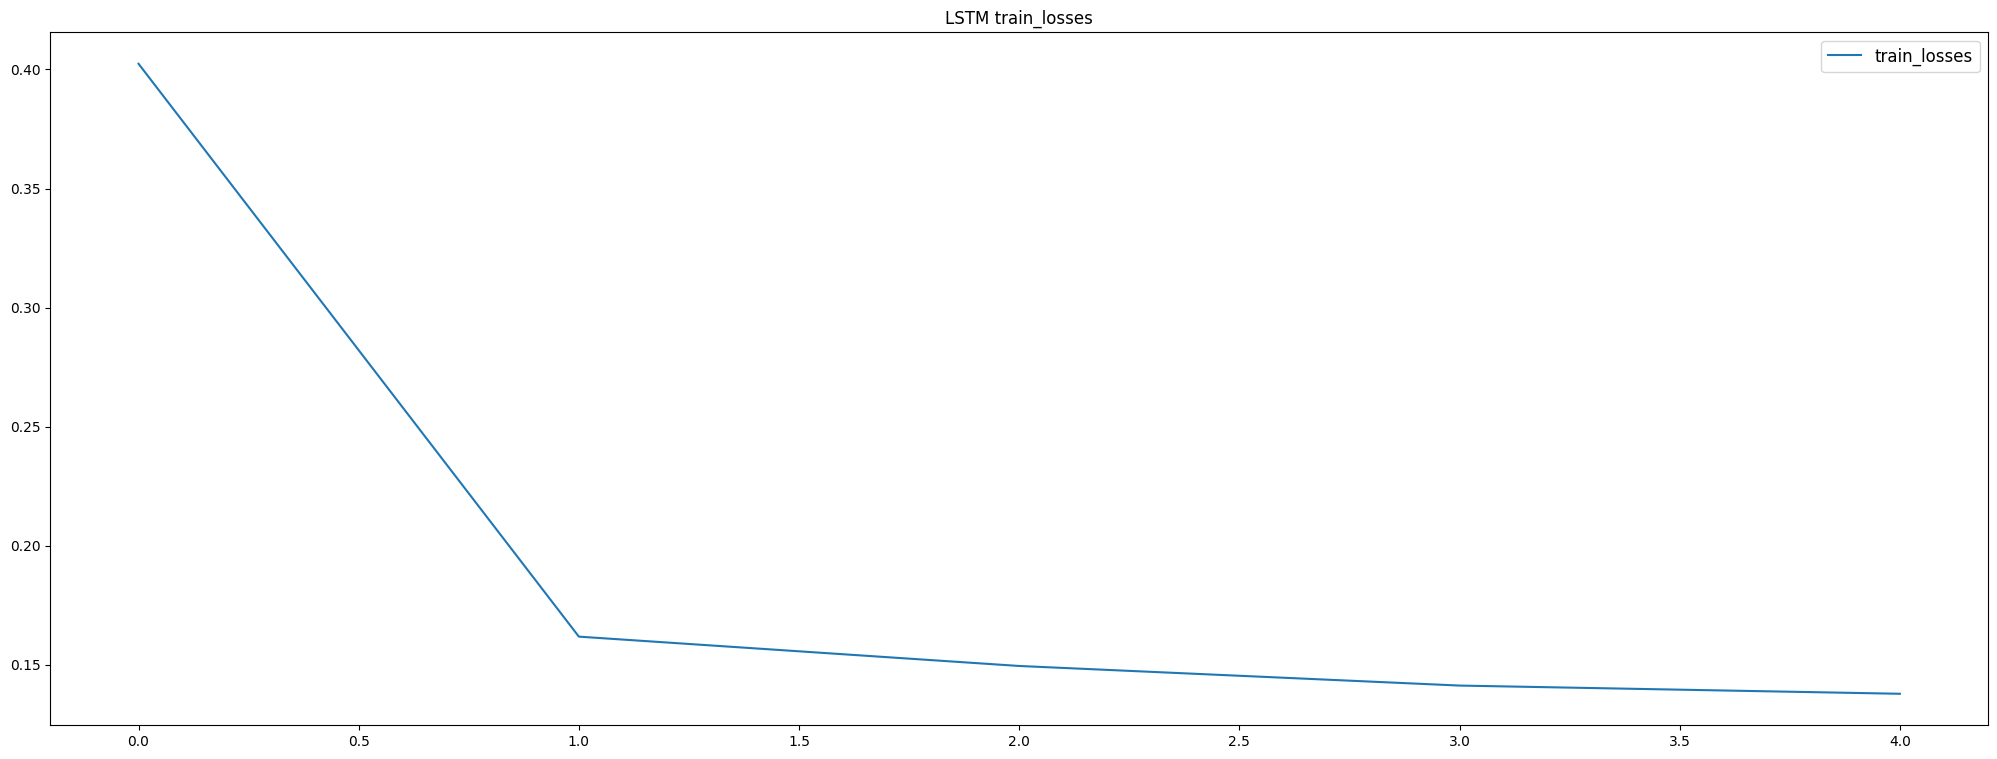

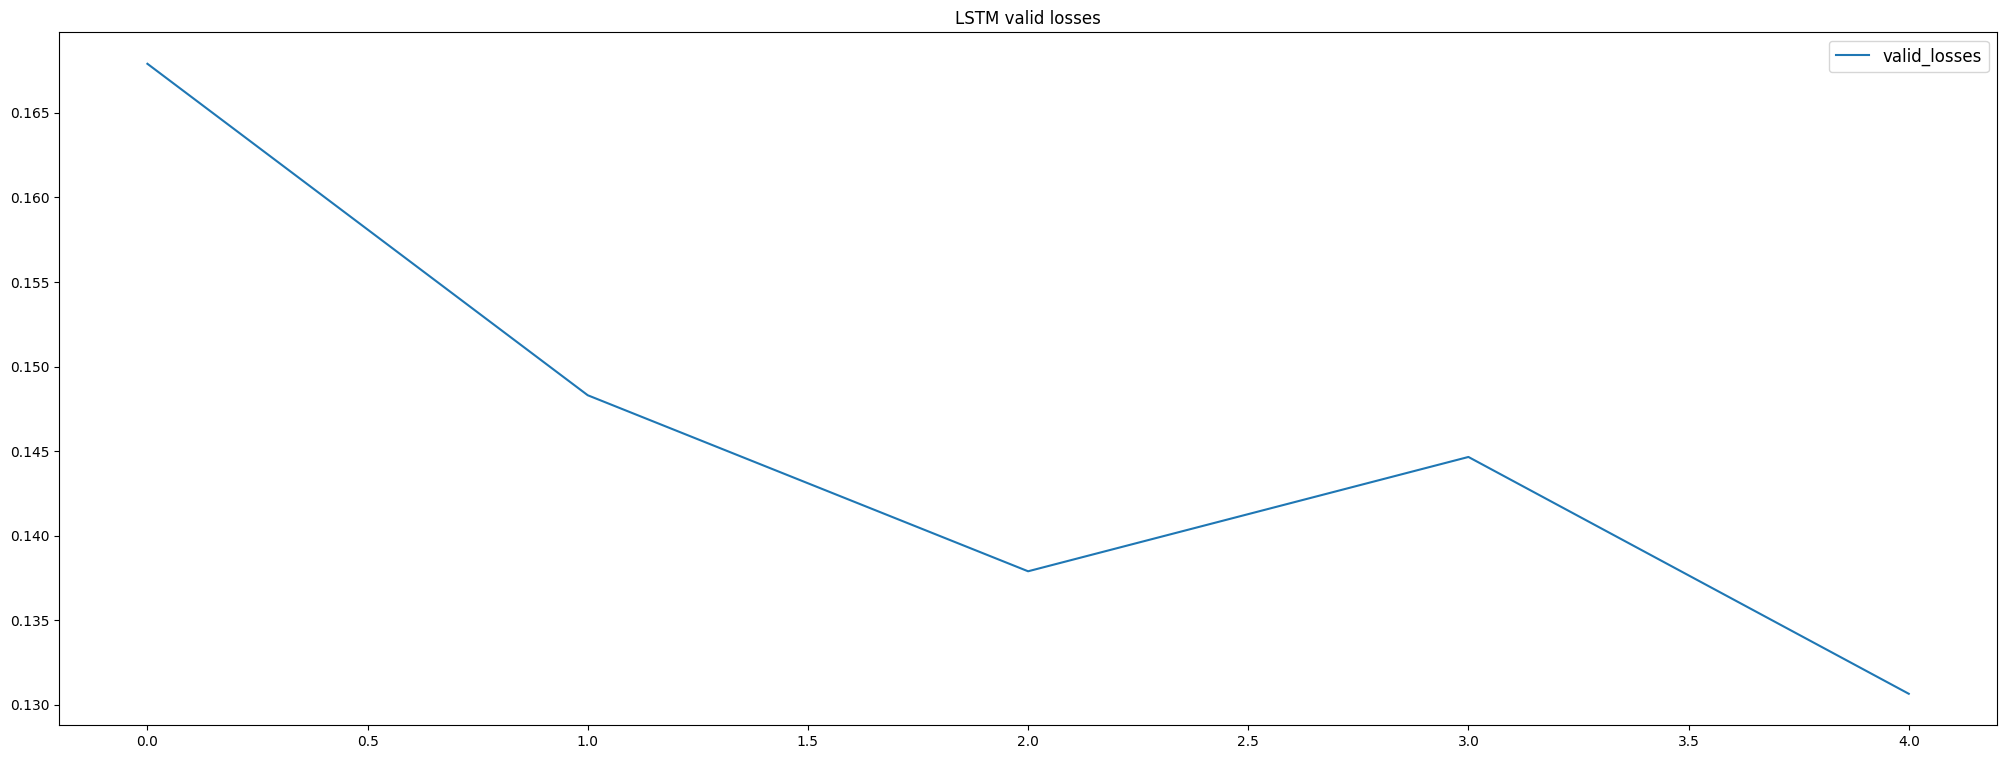

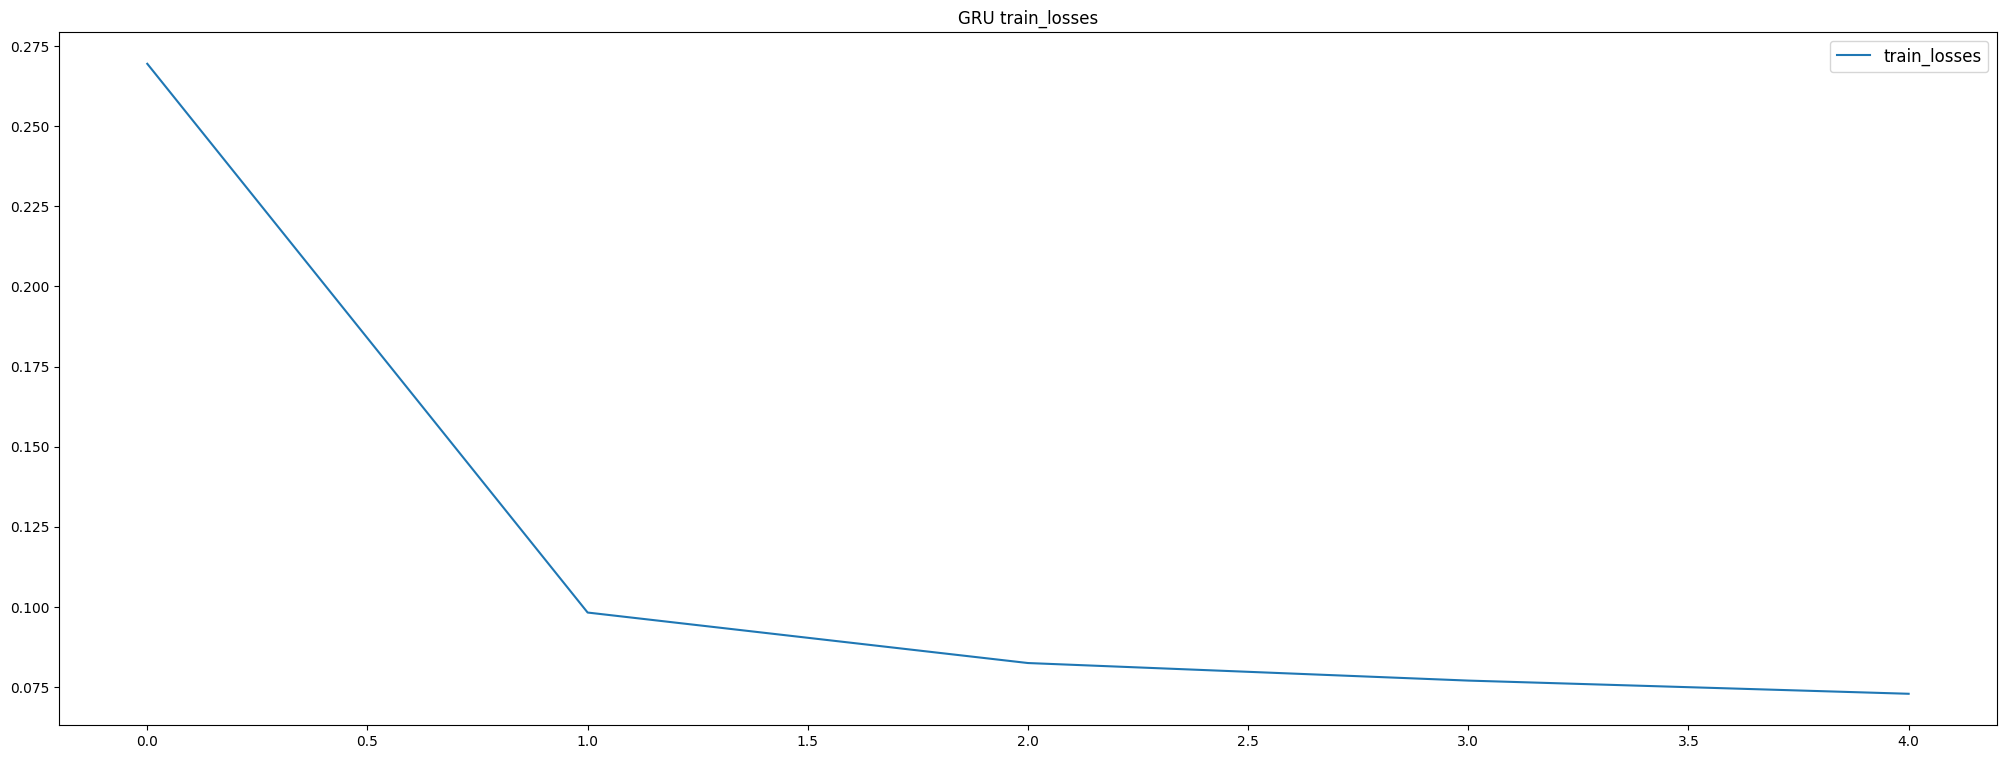

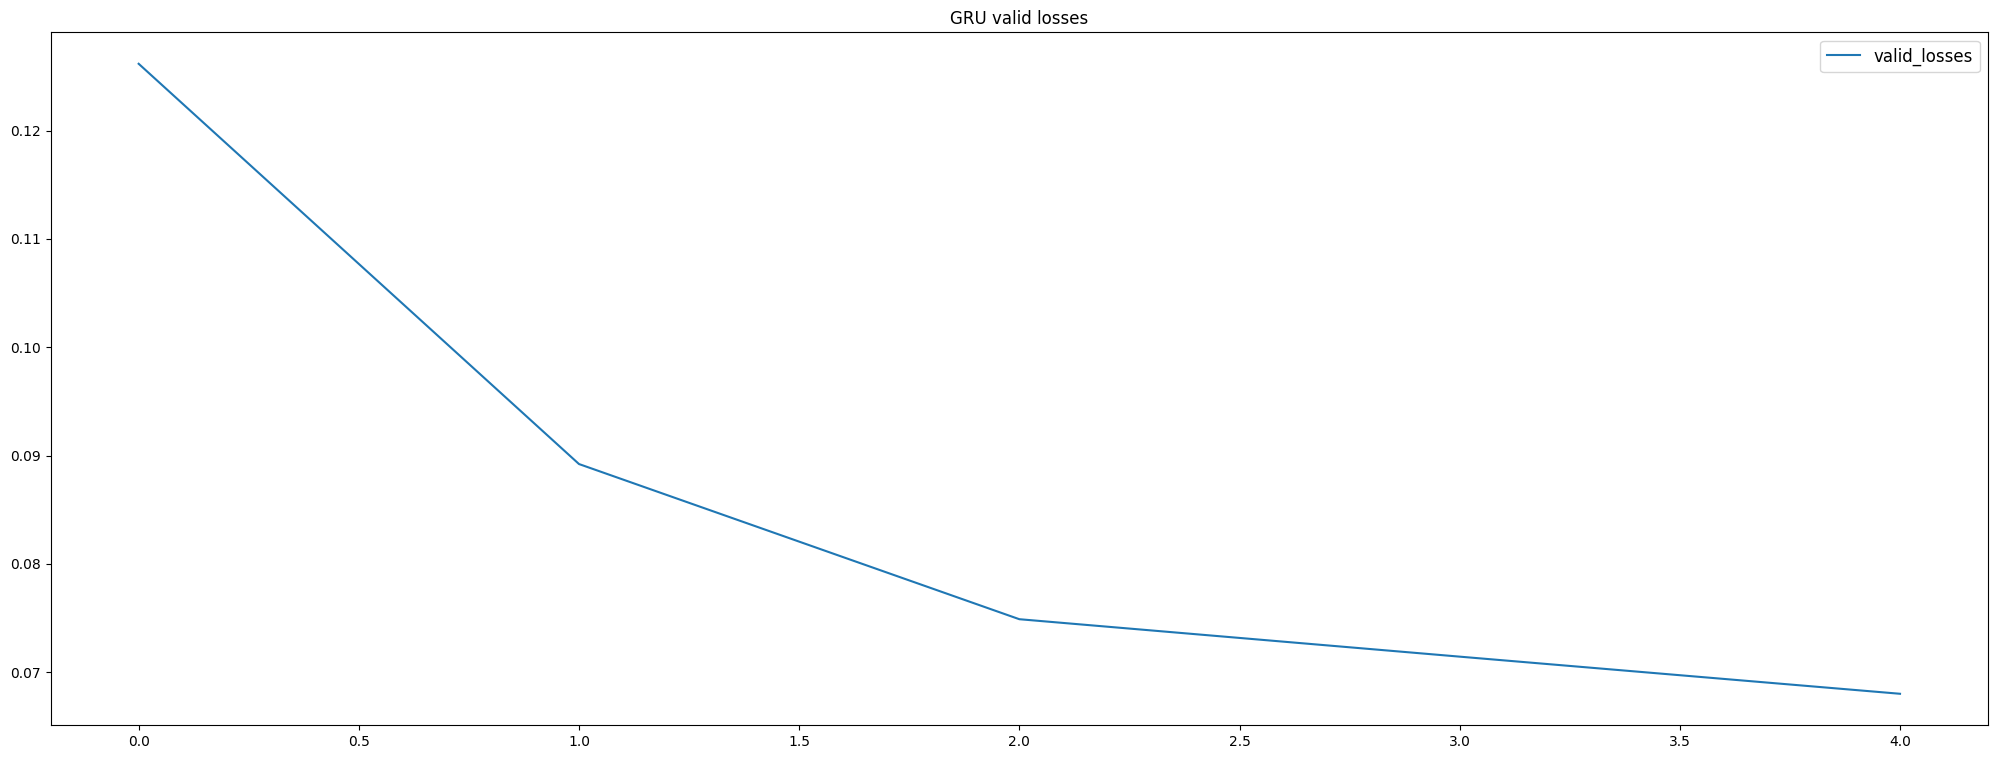

In [160]:
# LSTM
model_multivariate_LSTM = LSTMModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
train_loader_LSTM, val_loader_LSTM, test_loader_LSTM = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
_ , valid_losses, train_losses = train_model(model_multivariate_LSTM, train_loader_LSTM, val_loader_LSTM, 
                                            f"./{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl", 
                                            num_epochs=num_epochs_LSTM_multivariate, remove=False)
plot_losses(train_losses, "LSTM train_losses", "train_losses")
plot_losses(valid_losses, "LSTM valid losses", "valid_losses")

# GRU
model_multivariate_GRU = GRUModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
train_loader_GRU, val_loader_GRU, test_loader_GRU = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
_ , valid_losses, train_losses = train_model(model_multivariate_GRU, train_loader_GRU, val_loader_GRU, 
                                            f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl", 
                                            num_epochs=num_epochs_GRU_multivariate, remove=False)
plot_losses(train_losses, "GRU train_losses", "train_losses")
plot_losses(valid_losses, "GRU valid losses", "valid_losses")

## Results Multivariate vs Multivariate (TGCN VS LSTM - GRU)

RMSE                                                              \
           count      mean       std       min       25%       50%       75%   
Model_Name                                                                     
GRU Model   50.0  0.238617  0.178761  0.126942  0.159276  0.194070  0.241090   
LSTM Model  50.0  0.353980  0.185610  0.159134  0.223591  0.295211  0.393355   
TGCN Model  50.0  0.216229  0.107060  0.069112  0.148783  0.183554  0.246979   

                     SMAPE                                              \
                 max count       mean        std        min        25%   
Model_Name                                                               
GRU Model   1.168077  50.0  33.167436  17.541109  18.790076  25.035471   
LSTM Model  1.079527  50.0  48.577423  21.682704  20.192109  31.879386   
TGCN Model  0.650633  50.0  33.106438  15.354567  12.753077  23.221690   

                                             MAAPE                        \
                  50%        75%         max count       mean        std   
Model_Name                                                                 
GRU Model   29.161636  34.763850  138.316658  50.0  27.118761  10.826221   
LSTM Model  43.791000  59.777276  140.488484  50.0  36.707058  12.741253   
TGCN Model  29.263588  37.703506  101.347586  50.0  26.577283   8.596628   

                                                                   
                  min        25%        50%        75%        max  
Model_Name                                                         
GRU Model   16.002994  22.291885  25.089657  28.607304  90.223006  
LSTM Model  18.151723  26.995598  34.998767  42.680515  90.442894  
TGCN Model  11.827333  20.822930  26.429585  30.236021  52.461959

MAAPE                                                           
             count     mean        std    min      25%    50%      75%    max
Diff                                                                         
GRU vs LSTM   50.0  -9.5880   8.957130 -28.47 -17.7100 -7.810  -2.2875   3.84
GRU vs TGCN   50.0   0.5414   9.889505 -27.29  -4.6250  0.860   5.6925  37.76
LSTM vs GRU   50.0   9.5880   8.957130  -3.84   2.2875  7.810  17.7100  28.47
LSTM vs TGCN  50.0  10.1302  11.776349 -13.07   2.1450  8.875  16.1700  37.98
TGCN vs GRU   50.0  -0.5414   9.889505 -37.76  -5.6925 -0.860   4.6250  27.29
TGCN vs LSTM  50.0 -10.1302  11.776349 -37.98 -16.1700 -8.875  -2.1450  13.07

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

([<matplotlib.axis.YTick at 0x23b906fe3e0>,
 [Text(0, 0.0, '0'),
  Text(0, 4.0, '4'),
  Text(0, 8.0, '8'),
  Text(0, 12.0, '12'),
  Text(0, 16.0, '16'),
  Text(0, 20.0, '20'),
  Text(0, 24.0, '24'),
  Text(0, 28.0, '28'),
  Text(0, 32.0, '32'),
  Text(0, 36.0, '36'),
  Text(0, 40.0, '40'),
  Text(0, 44.0, '44'),
  Text(0, 48.0, '48'),
  Text(0, 52.0, '52'),
  Text(0, 56.0, '56'),
  Text(0, 60.0, '60'),
  Text(0, 64.0, '64'),
  Text(0, 68.0, '68'),
  Text(0, 72.0, '72'),
  Text(0, 76.0, '76'),
  Text(0, 80.0, '80'),
  Text(0, 84.0, '84'),
  Text(0, 88.0, '88')])

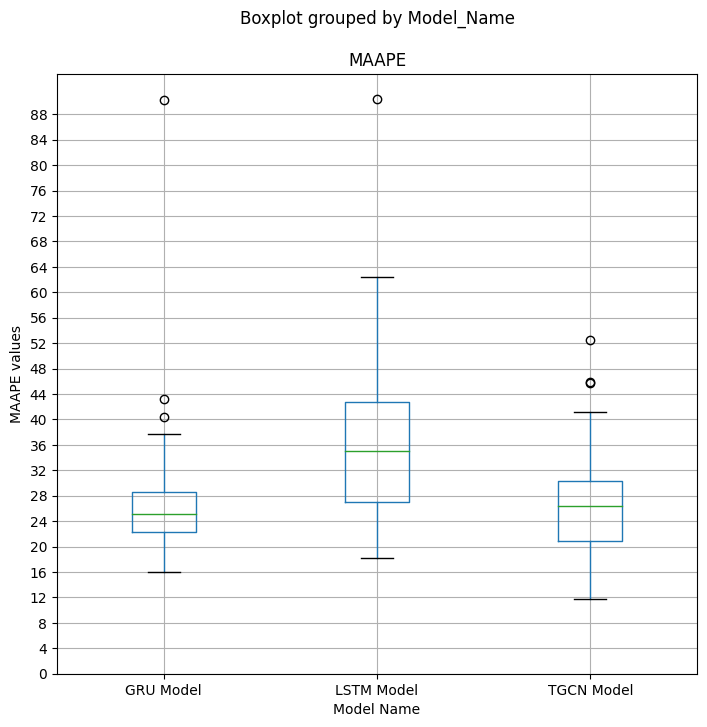

In [163]:
import matplotlib.pyplot as plt

final_resultats = []
diff_resultats = []

######################################################################
# TGCN
######################################################################
# load best model
model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# Make predictions
predictions_TGCN, actuals_TGCN =  test_model(model_TGCN, test_loader_TGCN)


######################################################################
# LSTM
######################################################################
# load best model
model_multivariate_LSTM.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl".format(input)))
    
# Make predictions
predictions_LSTM, actuals_LSTM = test_model(model_multivariate_LSTM, 
                                test_loader_LSTM)


######################################################################
# GRU
######################################################################
# Load best model
model_multivariate_GRU.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl".format(input)))

# Make predictions
predictions_GRU, actuals_GRU = test_model(model_multivariate_GRU, 
                                test_loader_GRU)

for i in range(n_neighbors+1):

######################################################################
# TGCN
######################################################################
    # Save result for each captor
    temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
    temp.append("TGCN Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data = [temp]
    final_resultats.append(temp)

######################################################################
# LSTM
######################################################################
    # Save result
    temp = result_prediction(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

    temp.append("LSTM Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data.append(temp)
    final_resultats.append(temp)


######################################################################
# GRU
######################################################################
    # Save results
    temp = result_prediction(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
    temp.append("GRU Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data.append(temp)
    final_resultats.append(temp)


######################################################################
# Dataframe
######################################################################
    df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])

    df.set_index(["Captor", 'Model_Name'], inplace=True)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)

    min_val = df['MAAPE'].min()
    max_val = df['MAAPE'].max()

    df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)

#######################################################################
# Plots
#######################################################################
final_resultats = pd.DataFrame(final_resultats, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])
final_resultats.set_index(["Captor", 'Model_Name'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
final_resultats.to_pickle(f"{path_save_model}/final_resultats.pkl")

stats = {
    "TGCN Model" : {"nb_win" : 0},
    "LSTM Model" : {"nb_win" : 0},
    "GRU Model" :  {"nb_win" : 0}
}

for i in final_resultats.index.get_level_values("Captor").unique():
    stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] = stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] + 1
    diff_resultats.append(["TGCN vs LSTM", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
    diff_resultats.append(["TGCN vs GRU", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
    diff_resultats.append(["LSTM vs TGCN", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
    diff_resultats.append(["LSTM vs GRU", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
    diff_resultats.append(["GRU vs TGCN", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
    diff_resultats.append(["GRU vs LSTM", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
diff_resultats = pd.DataFrame(diff_resultats, columns=["Diff", "MAAPE"])
diff_resultats.set_index(["Diff"], inplace=True)
display(diff_resultats.groupby("Diff").describe())
diff_resultats.groupby("Diff").describe().to_pickle(f"{path_save_model}/diff_results.pkl")

import numpy as np

bar_plot_results = final_resultats.reset_index()
display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))

In [ ]:
final_resultats = pd.read_pickle(f"{path_save_model}/final_resultats.pkl")
display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
diff_results = pd.read_pickle(f"{path_save_model}/diff_results.pkl")
display(diff_results)

bar_plot_results = final_resultats.reset_index()
display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))

## Multi_Experiments

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   11.0  16.254435  18.801745  3.743922   9.490706  11.852079   
LSTM Model  11.0  26.911804  29.108374  5.896179  13.489215  19.639196   
TGCN Model  11.0  18.653839  14.248725  6.832155  11.786303  13.341011   

                                  SMAPE                                \
                  75%         max count      mean       std       min   
Model_Name                                                              
GRU Model   13.688091   72.111847  11.0  6.961572  6.358930  2.949255   
LSTM Model  26.204569  111.397164  11.0  9.376463  7.283908  3.988377   
TGCN Model  18.460193   55.870115  11.0  9.177309  8.440123  4.219086   

                                                    MAAPE                      \
                 25%       50%       75%        max count      mean       std   
Model_Name                                                                      
GRU Model   3.514517  4.401133  5.611560  22.613015  11.0  6.651970  5.375186   
LSTM Model  5.541879  6.583122  8.461649  25.007640  11.0  9.014043  6.529470   
TGCN Model  4.589677  5.222764  7.517512  26.834451  11.0  8.408195  6.963901   

                                                               
                 min       25%       50%       75%        max  
Model_Name                                                     
GRU Model   2.993056  3.507451  4.356028  5.917222  18.594545  
LSTM Model  3.955294  5.425592  6.179290  8.857406  22.692276  
TGCN Model  4.146003  4.677071  5.397918  6.973456  23.438837

MAAPE                                                    
             count      mean       std   min    25%   50%    75%   max
Diff                                                                  
GRU vs LSTM   11.0 -2.361818  1.862368 -6.75 -2.835 -2.08 -1.275  0.09
GRU vs TGCN   11.0 -1.756364  2.226451 -7.50 -2.460 -1.46 -0.435  0.96
LSTM vs GRU   11.0  2.361818  1.862368 -0.09  1.275  2.08  2.835  6.75
LSTM vs TGCN  11.0  0.605455  1.954305 -2.72 -0.280  0.34  1.455  5.08
TGCN vs GRU   11.0  1.756364  2.226451 -0.96  0.435  1.46  2.460  7.50
TGCN vs LSTM  11.0 -0.605455  1.954305 -5.08 -1.455 -0.34  0.280  2.72

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   21.0  17.821126  11.346501  4.266701  11.816583  16.036574   
LSTM Model  21.0  26.786418  23.854933  7.356436  15.871710  22.749350   
TGCN Model  21.0  18.465616  14.096998  5.222745  10.416835  15.720572   

                                  SMAPE                                \
                  75%         max count      mean       std       min   
Model_Name                                                              
GRU Model   20.557299   60.317476  21.0  7.660400  6.097695  3.155501   
LSTM Model  26.707472  125.046810  21.0  9.432191  6.915653  4.352722   
TGCN Model  19.861986   71.476251  21.0  7.720767  7.390592  3.116453   

                                                    MAAPE                      \
                 25%       50%       75%        max count      mean       std   
Model_Name                                                                      
GRU Model   4.668079  5.580637  7.047485  24.806677  21.0  7.373429  5.378495   
LSTM Model  5.965276  6.335832  8.540947  26.627264  21.0  9.037335  5.654767   
TGCN Model  4.252199  4.903842  6.038169  30.577276  21.0  7.031152  5.642245   

                                                               
                 min       25%       50%       75%        max  
Model_Name                                                     
GRU Model   3.144791  4.585493  5.638004  6.732310  23.324188  
LSTM Model  4.421839  5.916188  6.464538  8.964590  22.553639  
TGCN Model  3.088988  4.267906  4.858173  6.291068  23.684044

MAAPE                                                  
             count      mean       std   min   25%   50%   75%   max
Diff                                                                
GRU vs LSTM   21.0 -1.663810  1.831364 -8.30 -2.21 -1.50 -0.65  1.19
GRU vs TGCN   21.0  0.342857  1.869187 -2.85 -0.90  0.33  1.13  5.59
LSTM vs GRU   21.0  1.663810  1.831364 -1.19  0.65  1.50  2.21  8.30
LSTM vs TGCN  21.0  2.006667  2.177887 -1.55  0.94  1.73  2.67  7.80
TGCN vs GRU   21.0 -0.342857  1.869187 -5.59 -1.13 -0.33  0.90  2.85
TGCN vs LSTM  21.0 -2.006667  2.177887 -7.80 -2.67 -1.73 -0.94  1.55

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   31.0  21.112969  15.860653  5.838169  14.976223  19.426424   
LSTM Model  31.0  27.250855  21.858902  7.581039  18.561698  23.829359   
TGCN Model  31.0  17.918125  10.199201  5.095695  13.123237  16.260466   

                                  SMAPE                                \
                  75%         max count      mean       std       min   
Model_Name                                                              
GRU Model   22.805957   99.254389  31.0  9.911639  8.535899  4.079997   
LSTM Model  29.664309  135.433792  31.0  9.910098  6.626367  4.826068   
TGCN Model  20.211142   60.055771  31.0  7.767283  6.617281  2.667803   

                                                    MAAPE                      \
                 25%       50%       75%        max count      mean       std   
Model_Name                                                                      
GRU Model   4.938447  6.366533  8.331310  32.840149  31.0  8.679050  5.840547   
LSTM Model  6.354579  7.057816  9.524099  27.090150  31.0  9.317142  5.301665   
TGCN Model  4.695463  5.320283  6.535418  30.981398  31.0  7.223261  5.309153   

                                                               
                 min       25%       50%       75%        max  
Model_Name                                                     
GRU Model   4.196936  5.038206  6.302544  8.423703  23.968720  
LSTM Model  4.967022  6.401689  7.340950  9.505631  23.071882  
TGCN Model  2.681073  4.743470  5.309802  6.302082  25.312303

MAAPE                                                    
             count      mean       std   min    25%   50%    75%   max
Diff                                                                  
GRU vs LSTM   31.0 -0.636774  2.239258 -7.27 -1.405 -0.77 -0.475  6.32
GRU vs TGCN   31.0  1.456129  2.526763 -1.34 -0.235  0.95  2.235  9.65
LSTM vs GRU   31.0  0.636774  2.239258 -6.32  0.475  0.77  1.405  7.27
LSTM vs TGCN  31.0  2.094194  2.087761 -2.24  0.675  2.00  3.085  7.90
TGCN vs GRU   31.0 -1.456129  2.526763 -9.65 -2.235 -0.95  0.235  1.34
TGCN vs LSTM  31.0 -2.094194  2.087761 -7.90 -3.085 -2.00 -0.675  2.24

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   41.0  23.127968  17.954584  6.644808  15.018361  20.080090   
LSTM Model  41.0  26.679098  20.716444  8.215307  16.888253  23.651832   
TGCN Model  41.0  17.368690  10.317829  4.702199  11.112960  15.375402   

                                  SMAPE                                \
                  75%         max count      mean       std       min   
Model_Name                                                              
GRU Model   26.930756  125.748722  41.0  8.928248  6.501889  4.179399   
LSTM Model  30.034941  144.786724  41.0  9.597829  6.550024  4.316071   
TGCN Model  19.902922   66.123546  41.0  7.210594  6.658451  2.635345   

                                                    MAAPE                      \
                 25%       50%       75%        max count      mean       std   
Model_Name                                                                      
GRU Model   5.416493  6.439041  8.679176  27.680960  41.0  8.400243  5.173173   
LSTM Model  6.101612  6.771844  8.973971  27.716672  41.0  9.045153  5.257608   
TGCN Model  4.065445  4.615953  6.310886  31.179134  41.0  6.574605  5.179362   

                                                               
                 min       25%       50%       75%        max  
Model_Name                                                     
GRU Model   4.226065  5.277694  6.575763  8.217362  22.765225  
LSTM Model  4.350027  6.126512  6.916616  9.158564  24.549262  
TGCN Model  2.669003  4.027602  4.652831  6.275029  24.493714

MAAPE                                                  
             count      mean       std   min   25%   50%   75%   max
Diff                                                                
GRU vs LSTM   41.0 -0.645854  1.260982 -4.69 -1.25 -0.32 -0.02  2.00
GRU vs TGCN   41.0  1.826585  1.756603 -2.56  0.71  1.68  2.58  8.36
LSTM vs GRU   41.0  0.645854  1.260982 -2.00  0.02  0.32  1.25  4.69
LSTM vs TGCN  41.0  2.471220  2.014004 -0.45  1.05  2.15  3.49  8.48
TGCN vs GRU   41.0 -1.826585  1.756603 -8.36 -2.58 -1.68 -0.71  2.56
TGCN vs LSTM  41.0 -2.471220  2.014004 -8.48 -3.49 -2.15 -1.05  0.45

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   51.0  29.203864  27.291708  7.912011  18.263037  23.040636   
LSTM Model  51.0  30.388961  28.643922  8.123793  19.017598  24.728633   
TGCN Model  51.0  19.768147  12.545494  3.732915  12.594731  17.656379   

                                  SMAPE                                 \
                  75%         max count       mean       std       min   
Model_Name                                                               
GRU Model   30.849615  172.087659  51.0  10.842754  9.566397  4.334341   
LSTM Model  32.461403  179.458910  51.0  10.373357  8.568052  4.482607   
TGCN Model  22.137666   66.060820  51.0   7.990632  6.189134  3.169015   

                                                    MAAPE             \
                 25%       50%       75%        max count       mean   
Model_Name                                                             
GRU Model   6.465862  7.022571  9.078261  55.086428  51.0  10.213736   
LSTM Model  6.318120  7.503939  9.888205  55.286797  51.0  10.109742   
TGCN Model  4.544821  5.680511  7.453019  28.832486  51.0   7.675379   

                                                                         
                 std       min       25%       50%       75%        max  
Model_Name                                                               
GRU Model   8.866607  4.370032  6.438464  7.218161  8.993683  59.625706  
LSTM Model  8.563764  4.555244  6.315684  7.455162  9.721731  60.376101  
TGCN Model  5.490386  3.109105  4.600916  5.646347  7.431228  25.730765

MAAPE                                                      
             count      mean       std    min    25%   50%    75%    max
Diff                                                                    
GRU vs LSTM   51.0  0.104118  1.549600  -4.53 -0.560  0.11  0.610   4.55
GRU vs TGCN   51.0  2.538235  5.480732  -8.92  0.915  1.83  3.140  36.65
LSTM vs GRU   51.0 -0.104118  1.549600  -4.55 -0.610 -0.11  0.560   4.53
LSTM vs TGCN  51.0  2.434118  5.635104  -8.74  0.620  1.83  3.470  37.40
TGCN vs GRU   51.0 -2.538235  5.480732 -36.65 -3.140 -1.83 -0.915   8.92
TGCN vs LSTM  51.0 -2.434118  5.635104 -37.40 -3.470 -1.83 -0.620   8.74

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   61.0  27.124252  25.700984  7.736240  17.481597  23.921770   
LSTM Model  61.0  29.635583  26.677067  8.058761  18.662309  25.948651   
TGCN Model  61.0  19.428297  13.861553  3.699905  12.056827  17.260852   

                                  SMAPE                                 \
                  75%         max count       mean       std       min   
Model_Name                                                               
GRU Model   27.976197  179.582316  61.0  10.187275  8.969316  4.244164   
LSTM Model  33.248552  182.069530  61.0  10.246413  8.508080  4.089791   
TGCN Model  20.466799   75.218266  61.0   8.050166  6.863724  3.202125   

                                                    MAAPE                      \
                 25%       50%       75%        max count      mean       std   
Model_Name                                                                      
GRU Model   6.246697  6.836035  8.660668  55.367613  61.0  9.808970  8.481963   
LSTM Model  6.344813  7.249611  8.989010  55.717170  61.0  9.976122  8.340686   
TGCN Model  4.375690  5.070065  7.617167  30.847304  61.0  7.612436  5.942364   

                                                               
                 min       25%       50%       75%        max  
Model_Name                                                     
GRU Model   4.282893  6.188776  6.913872  8.554414  60.435355  
LSTM Model  4.102966  6.321905  7.185118  9.318904  60.927449  
TGCN Model  3.187425  4.381172  5.132958  7.489606  30.679546

MAAPE                                                    
             count      mean       std    min   25%   50%   75%    max
Diff                                                                  
GRU vs LSTM   61.0 -0.167049  1.227440  -2.73 -0.80 -0.23  0.19   5.81
GRU vs TGCN   61.0  2.196393  4.805382 -11.66  0.41  2.04  3.39  29.76
LSTM vs GRU   61.0  0.167049  1.227440  -5.81 -0.19  0.23  0.80   2.73
LSTM vs TGCN  61.0  2.363770  4.883130 -10.89  0.68  2.01  3.67  30.25
TGCN vs GRU   61.0 -2.196393  4.805382 -29.76 -3.39 -2.04 -0.41  11.66
TGCN vs LSTM  61.0 -2.363770  4.883130 -30.25 -3.67 -2.01 -0.68  10.89

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   71.0  26.498737  24.884843  6.365714  16.251690  23.053765   
LSTM Model  71.0  27.429745  25.722042  5.652109  16.580164  22.689854   
TGCN Model  71.0  17.289948   9.210609  4.918019  12.136032  15.708611   

                                  SMAPE                                \
                  75%         max count      mean       std       min   
Model_Name                                                              
GRU Model   29.606316  182.984248  71.0  9.616070  8.344172  3.898709   
LSTM Model  28.181146  184.418711  71.0  9.549580  8.084427  4.092372   
TGCN Model  20.503094   62.193486  71.0  7.065559  5.857789  2.836046   

                                                    MAAPE                      \
                 25%       50%       75%        max count      mean       std   
Model_Name                                                                      
GRU Model   6.021960  6.910260  8.498473  55.774026  71.0  9.303683  7.868306   
LSTM Model  5.952020  6.871249  7.980936  56.099735  71.0  9.328712  7.957783   
TGCN Model  4.268515  5.134530  6.581848  29.879657  71.0  6.696065  4.864873   

                                                               
                 min       25%       50%       75%        max  
Model_Name                                                     
GRU Model   3.980327  6.126368  6.946221  8.728568  60.772637  
LSTM Model  4.088801  5.996573  6.855671  8.314795  61.160944  
TGCN Model  2.801393  4.272887  4.983544  6.539778  25.039725

MAAPE                                                    
             count      mean       std    min   25%   50%   75%    max
Diff                                                                  
GRU vs LSTM   71.0 -0.025070  0.962073  -2.52 -0.44  0.02  0.51   2.35
GRU vs TGCN   71.0  2.607324  4.978850  -1.86  0.92  1.77  3.02  40.76
LSTM vs GRU   71.0  0.025070  0.962073  -2.35 -0.51 -0.02  0.44   2.52
LSTM vs TGCN  71.0  2.632254  5.118366  -1.98  0.70  1.60  2.93  41.15
TGCN vs GRU   71.0 -2.607324  4.978850 -40.76 -3.02 -1.77 -0.92   1.86
TGCN vs LSTM  71.0 -2.632254  5.118366 -41.15 -2.93 -1.60 -0.70   1.98

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   81.0  26.239995  23.554690  7.184113  14.881591  21.588677   
LSTM Model  81.0  27.279819  24.616162  5.810167  17.216958  22.643902   
TGCN Model  81.0  17.828397  11.227177  4.950008  10.721545  16.572215   

                                  SMAPE                                 \
                  75%         max count       mean       std       min   
Model_Name                                                               
GRU Model   30.952080  183.751077  81.0  10.710735  9.873223  3.868556   
LSTM Model  28.773741  182.857580  81.0  10.590184  9.045594  4.218384   
TGCN Model  20.150945   65.008511  81.0   8.360107  7.861701  2.718078   

                                                    MAAPE             \
                 25%       50%       75%        max count       mean   
Model_Name                                                             
GRU Model   6.153075  7.333655  8.998223  58.410926  81.0  10.272282   
LSTM Model  6.389346  7.281418  9.433470  55.877582  81.0  10.296362   
TGCN Model  4.481097  5.337423  7.502035  42.641111  81.0   7.785143   

                                                                         
                 std       min       25%       50%       75%        max  
Model_Name                                                               
GRU Model   8.927393  3.874269  6.156393  7.279264  9.168573  61.265786  
LSTM Model  8.567937  4.215907  6.406481  7.385222  9.514683  61.174710  
TGCN Model  6.416873  2.718319  4.482240  5.280847  7.490221  35.026149

MAAPE                                                    
             count      mean       std    min   25%   50%   75%    max
Diff                                                                  
GRU vs LSTM   81.0 -0.024074  1.238766  -3.49 -0.49 -0.11  0.42   6.01
GRU vs TGCN   81.0  2.487407  4.898026 -10.48  0.95  2.09  3.70  35.08
LSTM vs GRU   81.0  0.024074  1.238766  -6.01 -0.42  0.11  0.49   3.49
LSTM vs TGCN  81.0  2.511481  4.878996  -9.57  0.90  2.08  3.25  34.99
TGCN vs GRU   81.0 -2.487407  4.898026 -35.08 -3.70 -2.09 -0.95  10.48
TGCN vs LSTM  81.0 -2.511481  4.878996 -34.99 -3.25 -2.08 -0.90   9.57

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   91.0  26.629932  23.915643  5.857368  15.803137  21.433514   
LSTM Model  91.0  26.681339  24.103051  5.710888  16.183842  21.526527   
TGCN Model  91.0  17.114638   9.238678  3.589792  10.818294  15.773072   

                                  SMAPE                                  \
                  75%         max count       mean        std       min   
Model_Name                                                                
GRU Model   28.671071  186.435496  91.0  11.239649  10.991969  3.982135   
LSTM Model  28.423438  187.323479  91.0  11.179730  10.646472  4.264862   
TGCN Model  21.003459   64.919864  91.0   8.812756   9.342297  2.681021   

                                                     MAAPE             \
                 25%       50%        75%        max count       mean   
Model_Name                                                              
GRU Model   6.415986  7.187325   9.562469  71.407467  91.0  10.730873   
LSTM Model  6.266768  7.294576  10.458172  64.231968  91.0  10.797426   
TGCN Model  4.472804  5.591370   8.510588  65.000150  91.0   8.131790   

                                                                          
                 std       min       25%       50%        75%        max  
Model_Name                                                                
GRU Model   9.604543  4.036087  6.483082  7.186141   9.485561  61.561395  
LSTM Model  9.470399  4.291337  6.351541  7.377970  10.007124  62.065017  
TGCN Model  7.505062  2.682055  4.434208  5.572552   8.133350  50.836757

MAAPE                                                      
             count      mean       std    min    25%   50%    75%    max
Diff                                                                    
GRU vs LSTM   91.0 -0.066593  1.139125  -5.82 -0.630 -0.04  0.435   4.11
GRU vs TGCN   91.0  2.599011  4.735628  -7.62  0.475  2.23  3.740  34.59
LSTM vs GRU   91.0  0.066593  1.139125  -4.11 -0.435  0.04  0.630   5.82
LSTM vs TGCN  91.0  2.665055  4.823341  -7.33  0.605  2.18  3.870  35.09
TGCN vs GRU   91.0 -2.599011  4.735628 -34.59 -3.740 -2.23 -0.475   7.62
TGCN vs LSTM  91.0 -2.665055  4.823341 -35.09 -3.870 -2.18 -0.605   7.33

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

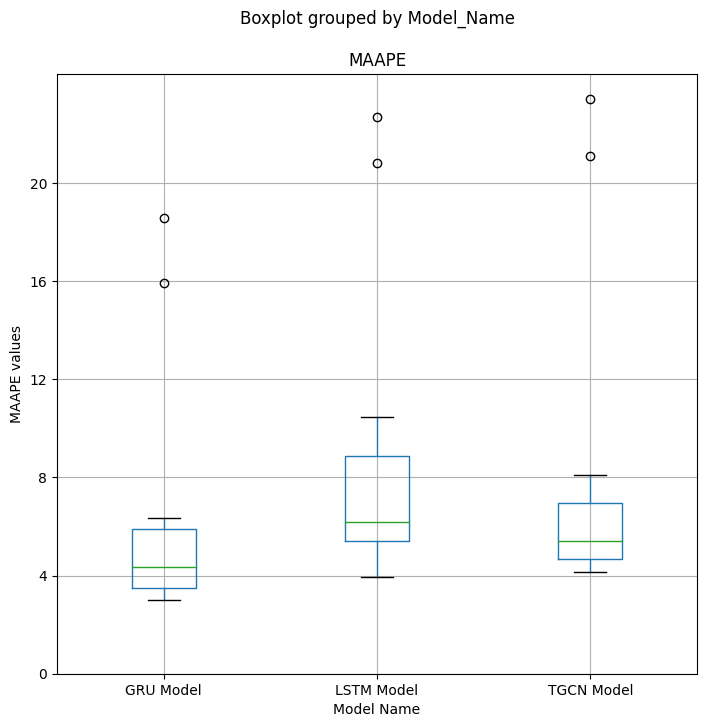

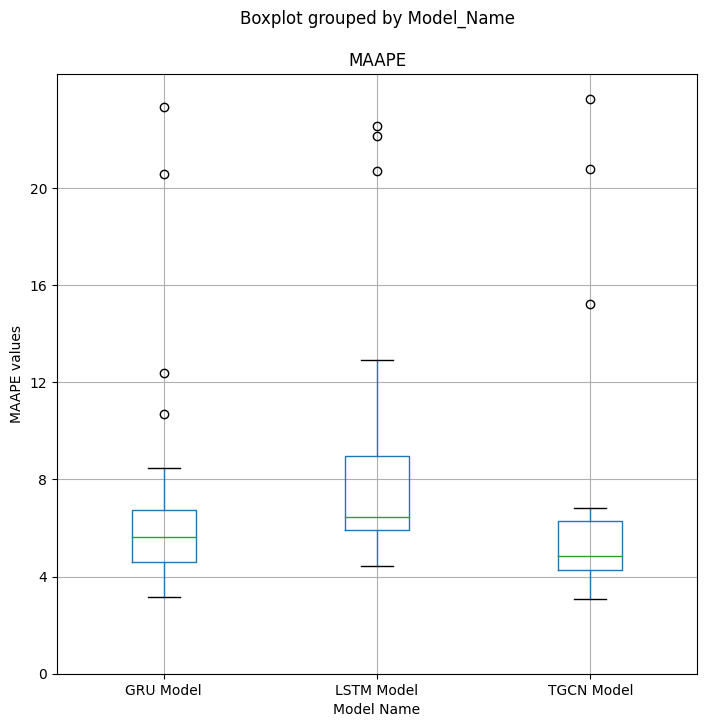

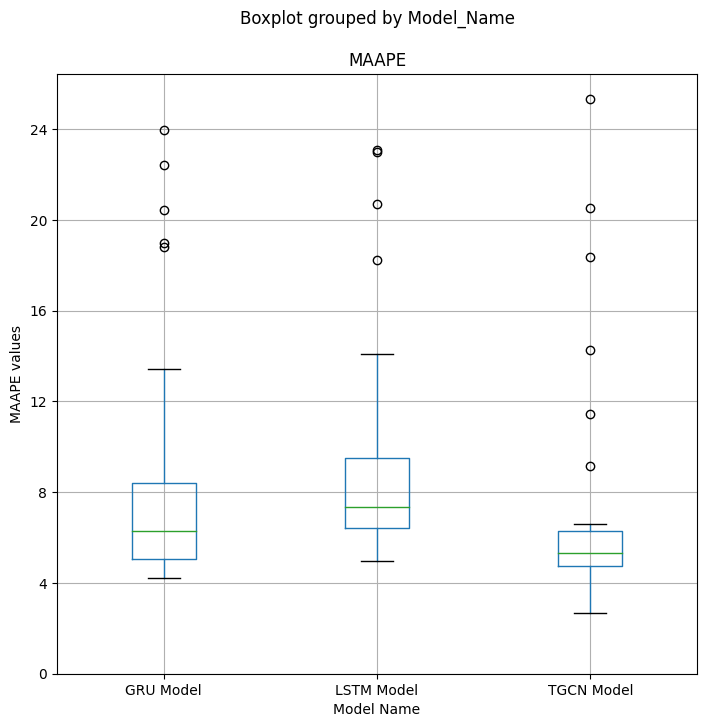

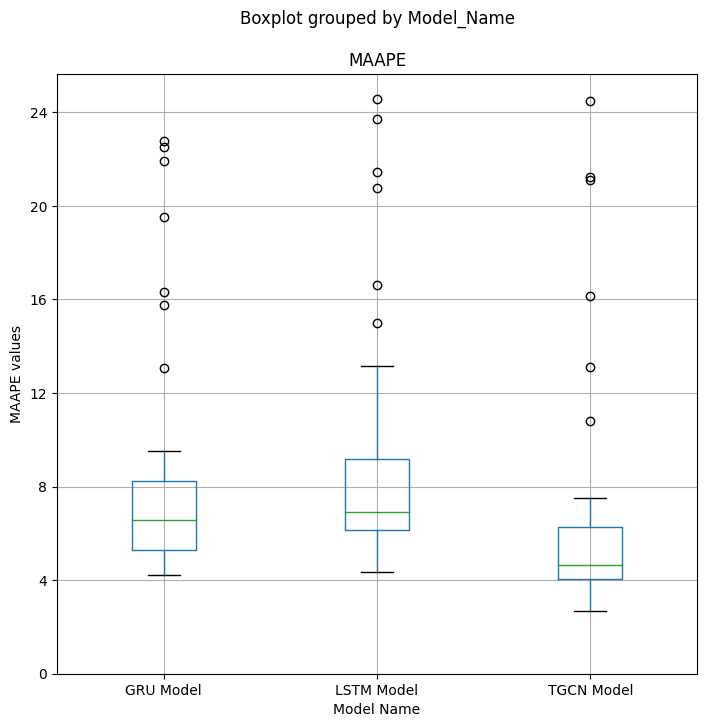

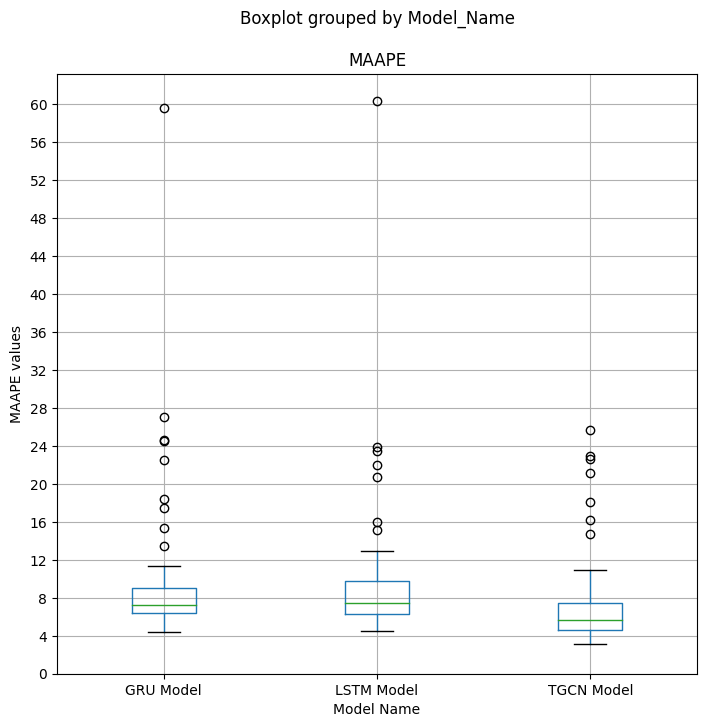

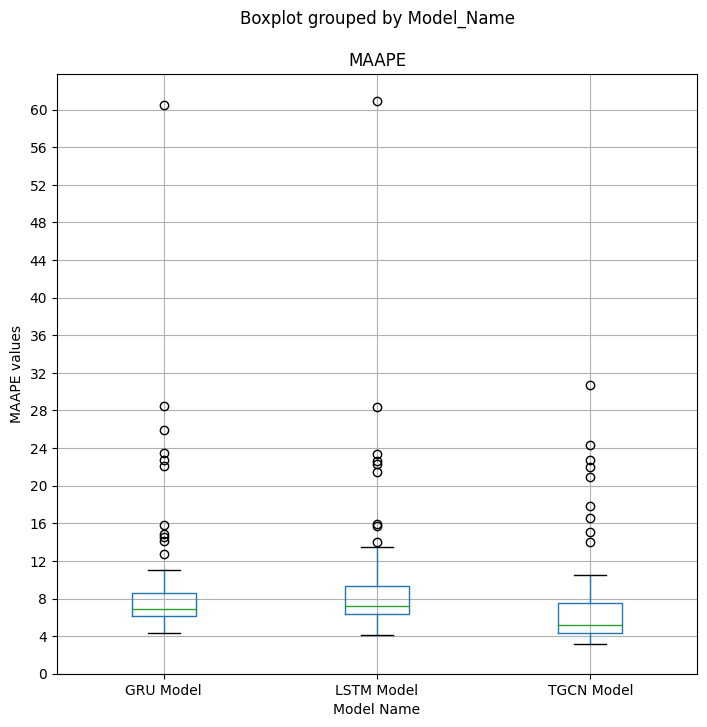

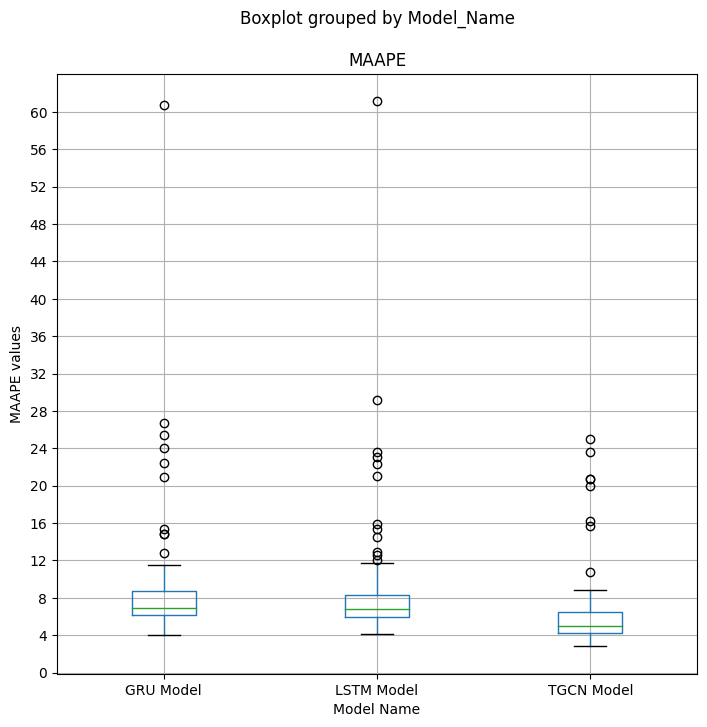

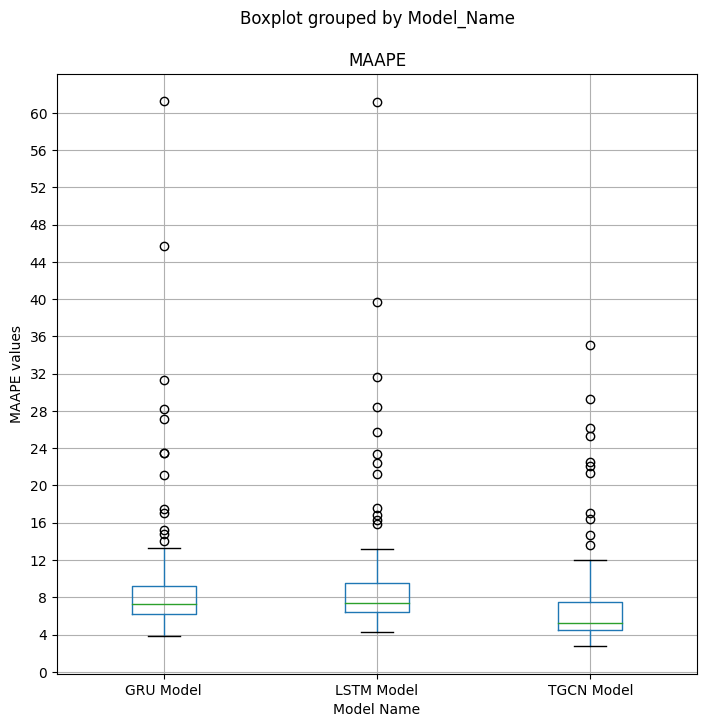

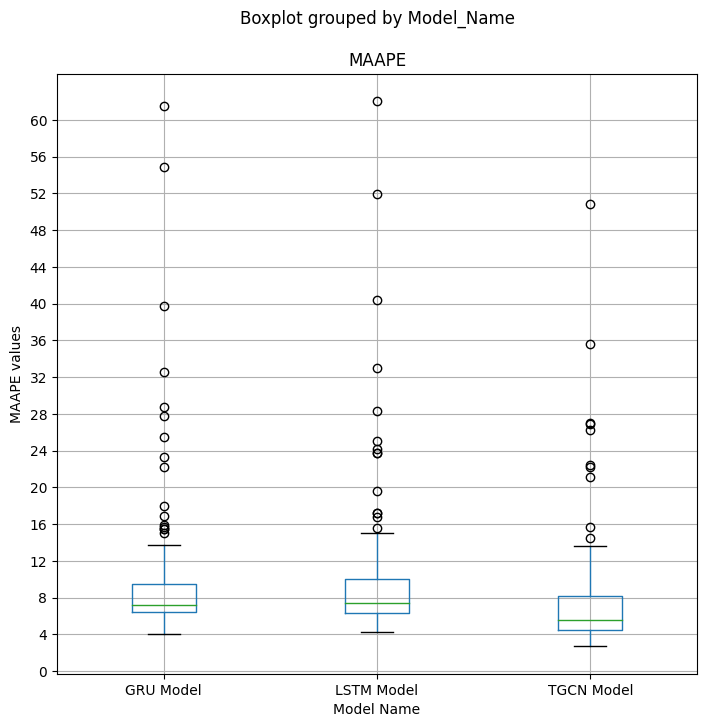

In [ ]:
# import matplotlib.pyplot as plt

# # Define the sliding window size and stride
# _window_size = 6
# horizon = 6
# _stride = horizon

# for i in range(30, 50, 10):
#     n_neighbors = i
#     path_save_model = f"./{normalization}/nb_captor_{n_neighbors+1}/windows_{_window_size}_out_{horizon}"
#     df_PeMS, adjacency_matrix_PeMS, meanstd_dict = preprocess_PeMS_data(df_PeMS_old, df_distance, init_node=0, n_neighbors=n_neighbors, center_and_reduce=True)
    
#     # TGCN
#     train_loader_TGCN, val_loader_TGCN, test_loader_TGCN = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
#     model_TGCN = TGCN(adjacency_matrix_PeMS, hidden_dim=32, output_size=len(df_PeMS.columns))

#     model_path = f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl"
#     _ , _, _ = train_model(model_TGCN, train_loader_TGCN, val_loader_TGCN, model_path=model_path, num_epochs=num_epochs_TGCN, remove=False)


#     # LSTM
#     model_multivariate_LSTM = LSTMModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
#     train_loader_LSTM, val_loader_LSTM, test_loader_LSTM = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
#     _ , _, _ = train_model(model_multivariate_LSTM, train_loader_LSTM, val_loader_LSTM, 
#                                                 f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl", 
#                                                 num_epochs=num_epochs_LSTM_multivariate, remove=False)

#     # GRU
#     model_multivariate_GRU = GRUModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
#     train_loader_GRU, val_loader_GRU, test_loader_GRU = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
#     _ , _, _ = train_model(model_multivariate_GRU, train_loader_GRU, val_loader_GRU, 
#                                                 f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl", 
#                                                 num_epochs=num_epochs_GRU_multivariate, remove=False)


#     final_resultats = []
#     diff_resultats = []

#     ######################################################################
#     # TGCN
#     ######################################################################
#     # load best model
#     model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

#     # Make predictions
#     predictions_TGCN, actuals_TGCN =  test_model(model_TGCN, test_loader_TGCN)


#     ######################################################################
#     # LSTM
#     ######################################################################
#     # load best model
#     model_multivariate_LSTM.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl".format(input)))
        
#     # Make predictions
#     predictions_LSTM, actuals_LSTM = test_model(model_multivariate_LSTM, 
#                                     test_loader_LSTM)


#     ######################################################################
#     # GRU
#     ######################################################################
#     # Load best model
#     model_multivariate_GRU.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl".format(input)))

#     # Make predictions
#     predictions_GRU, actuals_GRU = test_model(model_multivariate_GRU, 
#                                     test_loader_GRU)

#     for i in range(n_neighbors+1):

#     ######################################################################
#     # TGCN
#     ######################################################################
#         # Save result for each captor
#         temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                                 actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#         temp.append("TGCN Model")
#         temp.append(f"captor {df_PeMS.columns[i]}")
#         data = [temp]
#         final_resultats.append(temp)

#     ######################################################################
#     # LSTM
#     ######################################################################
#         # Save result
#         temp = result_prediction(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                                 actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#         temp.append("LSTM Model")
#         temp.append(f"captor {df_PeMS.columns[i]}")
#         data.append(temp)
#         final_resultats.append(temp)


#     ######################################################################
#     # GRU
#     ######################################################################
#         # Save results
#         temp = result_prediction(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                                 actuals_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#         temp.append("GRU Model")
#         temp.append(f"captor {df_PeMS.columns[i]}")
#         data.append(temp)
#         final_resultats.append(temp)


#     ######################################################################
#     # Dataframe
#     ######################################################################
#         df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])

#         df.set_index(["Captor", 'Model_Name'], inplace=True)

#         pd.set_option('display.max_columns', None)
#         pd.set_option('display.max_rows', None)
#         pd.set_option('display.width', None)

#         min_val = df['MAAPE'].min()
#         max_val = df['MAAPE'].max()

#         df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)

#     #######################################################################
#     # Plots
#     #######################################################################
#     final_resultats = pd.DataFrame(final_resultats, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])
#     final_resultats.set_index(["Captor", 'Model_Name'], inplace=True)
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)
#     display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
#     final_resultats.to_pickle(f"{path_save_model}/final_resultats.pkl")

#     stats = {
#         "TGCN Model" : {"nb_win" : 0},
#         "LSTM Model" : {"nb_win" : 0},
#         "GRU Model" :  {"nb_win" : 0}
#     }

#     for i in final_resultats.index.get_level_values("Captor").unique():
#         stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] = stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] + 1
#         diff_resultats.append(["TGCN vs LSTM", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
#         diff_resultats.append(["TGCN vs GRU", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
#         diff_resultats.append(["LSTM vs TGCN", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
#         diff_resultats.append(["LSTM vs GRU", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
#         diff_resultats.append(["GRU vs TGCN", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
#         diff_resultats.append(["GRU vs LSTM", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
#     diff_resultats = pd.DataFrame(diff_resultats, columns=["Diff", "MAAPE"])
#     diff_resultats.set_index(["Diff"], inplace=True)
#     display(diff_resultats.groupby("Diff").describe())
#     diff_resultats.groupby("Diff").describe().to_pickle(f"{path_save_model}/diff_results.pkl")

#     import numpy as np

#     bar_plot_results = final_resultats.reset_index()
#     display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
#     plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))